In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as img

In [217]:
def conv(imag,filt,stride,pad):

    cnv_1 = ((imag.shape[0] + 2*pad) - filt.shape[0])//stride + 1
    cnv_2 = ((imag.shape[1] + 2*pad) - filt.shape[1])//stride + 1
    
    b = np.zeros((filt.shape[0]*filt.shape[1],cnv_1*cnv_2),dtype="float32")
    
    z=0
    
    for i in range(cnv_1):
        v_start = i * stride
        v_end = v_start + filt.shape[0]
        for j in range(cnv_2):

            
            h_start = j * stride
            h_end = h_start + filt.shape[1]
            
            b[:,z] = imag[v_start:v_end,h_start:h_end].flatten()
            
            z+=1
    b=np.dot(np.reshape(filt,(filt.shape[0]*filt.shape[1],1)).T,b)
    
    return np.reshape(b,(cnv_1,cnv_2)) 



def max_pool(imag,stride,filt):
    
    cnv_1 = (imag.shape[0] - filt[0])//stride + 1
    cnv_2 = (imag.shape[1] - filt[1])//stride + 1
    
    pool = np.zeros((filt[0]*filt[1],cnv_1*cnv_2),dtype="float16")
    
    z=0
    for i in range(cnv_1):
        for j in range(cnv_2):
            v_start = i * stride
            v_end = v_start + filt[0]
            
            h_start = j * stride
            h_end = h_start + filt[1]
            
            pool[:,z] = imag[v_start:v_end,h_start:h_end].flatten()
            #print(imag[v_start:v_end,h_start:h_end].flatten())
            z+=1
    pool = np.max(pool,axis=0,keepdims=True)
    #print(pool.shape)
    return np.reshape(pool,(cnv_1,cnv_2))


def D_max_pool(imag,stride,filt,d):
    
    cnv_1 = (imag.shape[0] - filt[0])//stride + 1
    cnv_2 = (imag.shape[1] - filt[1])//stride + 1
    
    #pool = np.zeros((filt[0]*filt[1],cnv_1*cnv_2),dtype="float32")
    der = np.zeros((imag.shape[0],imag.shape[1]),dtype="float32")
    z=0
    for i in range(cnv_1):
        for j in range(cnv_2):
            v_start = i * stride
            v_end = v_start + filt[0]
            
            h_start = j * stride
            h_end = h_start + filt[1]
            
            maxx  = imag[v_start:v_end,h_start:h_end]
            #print(imag[v_start:v_end,h_start:h_end].flatten())
            #print(maxx, np.where(maxx == np.max(maxx),1,0))
            m = maxx == np.max(maxx)
            der[v_start:v_end,h_start:h_end] += m * d[i,j]
            #print(i,j,z,v_start, v_end,h_start ,h_end)
           # print(np.multiply(np.where(maxx == np.max(maxx),1,0),d[i,j]),"\n")
            z+=1
    return der

In [218]:
def relu(mat):
    return(np.multiply(mat,np.where(mat>=0,1,0)))

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def sigmoid_backward(A):
    da = sigmoid(A)
    return da*(1-da)
def relu_backward(A):
    return np.where(A>=0,1,0)



In [219]:
def compute_cost(AL,Y):

    m =Y.shape[1]
    
    cost = np.sum(np.multiply(Y,np.log(AL)),axis=1,keepdims=True) + np.sum(np.multiply(1-Y,np.log(1-AL)),axis=1,keepdims=True)
    cost=np.sum(cost)
    cost = cost/-m  
    
    cost = np.squeeze(cost) #(will turn [[13]] -> 13)
    
    assert(cost.shape == ())
    return cost

In [220]:
im = img.open("dog.jpg")
im = im.resize((250,250))
im = im.convert("L")

im = np.array(im)
print(im.shape)

(250, 250)


In [221]:
#fil = np.array(([1,1,1],[0,0,0],[-1,-1,-1])).T
W1 = np.random.rand(3,3)*0.01
W2 =  np.random.rand(3,3)*0.01
W3 = np.random.rand(1,3364)*0.01


In [222]:
y=np.ones((1,1))
print(y,y.shape)

[[1.]] (1, 1)


In [223]:
costs = []
Z1 = conv(im,W1,2,0)
A1 = relu(Z1)
P1 = max_pool(A1,1,(3,3))
Z2 = conv(P1,W2,2,0)
A2 = relu(Z2)
P2 = max_pool(A2,1,(3,3))
f_c = np.reshape(P2,(P2.shape[0]*P2.shape[1],1))
Z3 = np.dot(W3,f_c)
A3 = sigmoid(Z3)
cost=compute_cost(A3,y)
costs.append(cost)
print(costs)         
                


[0.005208317883380111]


In [234]:
print(P1.shape,W2.shape,P2.shape)

(122, 122) (3, 3) (58, 58)


In [231]:
dZ3 = A3 - y
dW3 = np.dot(dZ3,f_c.T)
dF_c = np.dot(W3.T,dZ3)
dF_c = np.reshape(dF_c,(P2.shape[0],P2.shape[1]))
print(dF_c.shape,P2.shape,f_c.shape)
dA2 = D_max_pool(A2,1,(3,3),dF_c)
dZ2 = np.multiply(dA2,relu_backward(Z2))
dW2 = conv(P1,dZ2,2,0)
print(dW2.shape,W2.shape,P1.shape,dZ2.shape,im.shape,Z1.shape)

(58, 58) (58, 58) (3364, 1)
(32, 32) (3, 3) (122, 122) (60, 60) (250, 250) (124, 124)


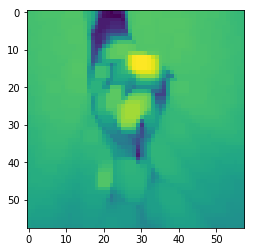

In [92]:
plt.imshow(P2)

CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

In [93]:
print(A3.shape,A3,cost)

(1, 1) [[0.99888203]] 0.0011185907880314036


In [103]:
fo = np.array(([1,1,0,1],[1,0,1,1],[0,1,1,1],[1,1,1,0]))
fil=np.random.randint(4,size=(2,2))

In [104]:
print(fo)
print(fil)

[[1 1 0 1]
 [1 0 1 1]
 [0 1 1 1]
 [1 1 1 0]]
[[2 3]
 [3 3]]


In [105]:
print(fo*fil)

ValueError: operands could not be broadcast together with shapes (4,4) (2,2) 

In [155]:
#a=np.array(([1,2,-3,3],[3,4,9,-9],[0,3,2,1],[-1,2,6,7]))
a=np.random.randint(30,size=(5,5))
print(a)

[[24 21 19  0  5]
 [19 20 13 16 25]
 [21  2  8  4 27]
 [25  4 11 28  7]
 [13 29  8 12 14]]


In [156]:
print(relu(a))

[[24 21 19  0  5]
 [19 20 13 16 25]
 [21  2  8  4 27]
 [25  4 11 28  7]
 [13 29  8 12 14]]


In [165]:
f=max_pool(relu(a),1,(2,2))
print(f)

[[24. 21. 19. 25.]
 [21. 20. 16. 27.]
 [25. 11. 28. 28.]
 [29. 29. 28. 28.]]


In [196]:
print(D_max_pool(relu(a),1,(2,2),f))

[[ 24.  21.  19.   0.   0.]
 [  0.  20.   0.  16.  25.]
 [ 21.   0.   0.   0.  27.]
 [ 25.   0.  11. 112.   0.]
 [  0.  58.   0.   0.   0.]]
None


In [192]:
print(2828)

1.0


In [ ]:
#                 
# Z1 = conv(im,W1,2,0)
# A1 = relu(Z1)
# P1 = max_pool(A1,1,W1)
# Z2 = conv(P1,W2,2,0)
# A2 = relu(Z2)
# P2 = max_pool(A2,1,W2)
# f_c = np.reshape(P2,(P2.shape[0]*P2.shape[1],1))
# Z3 = np.dot(W3,f_c)
# A3 = sigmoid(Z3)
# cost=compute_cost(A3,y)
# costs.append(cost)
# dZ3